# FPS-URB-RCC STAGE-0 WRF sensitivity experiment design

The simulation of this experiment are collected in [FPS-URB-RCC_STAGE-0_WRF_experiment_design.yaml](./FPS-URB-RCC_STAGE-0_WRF_experiment_design.yaml).

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import yaml

## Directed graph

In [2]:
def plot_graph(simul_data):
    G = nx.DiGraph()
    for node in simul_data['simulations']:
        label = f"{node['simulation_id']}\n({node['institution_id']})"
        G.add_node(node['simulation_id'], label=label)
        parent_id = node.get('parent_id')
        if parent_id is not None:
            G.add_edge(parent_id, node['simulation_id'])
    pos = nx.spring_layout(G)
    #pos = nx.circular_layout(G)
    #pos = nx.shell_layout(G)
    labels = {k: v['label'] for k, v in G.nodes.items()}
    # Plot
    plt.figure(figsize=(14, 8))
    nx.draw(
        G, pos, labels=labels, with_labels=True,
        node_size=4000, node_color='skyblue', node_shape='s'
    )
    plt.show()

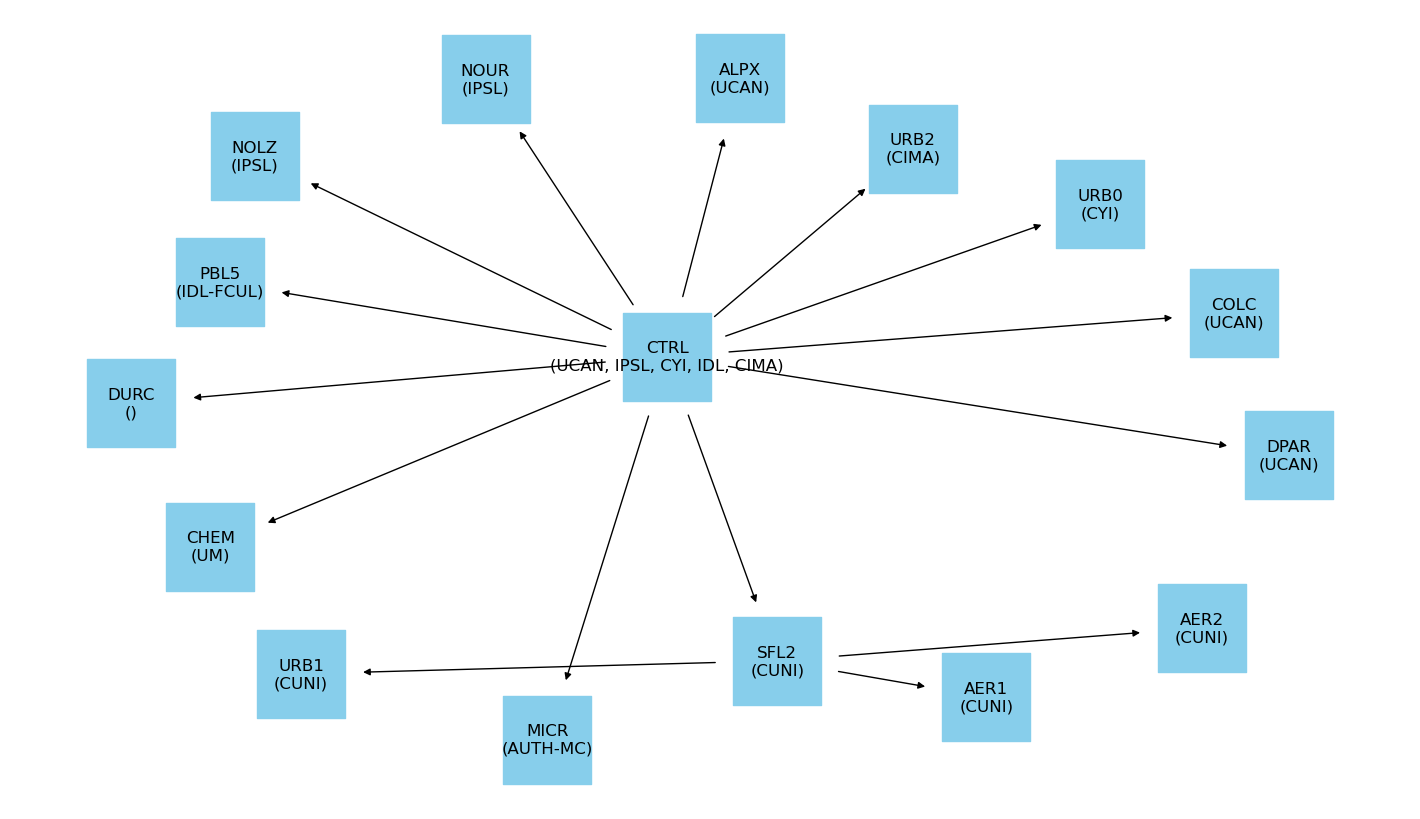

In [3]:
with open('FPS-URB-RCC_STAGE-0_WRF_experiment_design.yaml', 'r') as file:
    simul_data = yaml.safe_load(file)
plot_graph(simul_data)

## Simulation table

In [4]:
df = pd.DataFrame()
for sim in simul_data['simulations']:
    df = df.append(sim, ignore_index=True)
df.set_index("simulation_id", inplace=True)
df = df[["parent_id", "simulation", "institution_id", "parameters", "description"]]
df

,parent_id,simulation,institution_id,parameters,description
simulation_id,,,,,
CTRL,NaN,Control simulation,"UCAN, IPSL, CYI, CIMA",None,EUR-12 -> PAR-3 nesting. WUDAPT LCZs on LANDM...
URB2,CTRL,BEP model,CIMA,{'sf_urban_physics': 2},"As CTRL run, but with BEP urban model"
URB1,CTRL,SLUCM model,,{'sf_urban_physics': 1},"As CTRL run, but with SLUCM urban model"
URB0,CTRL,"No urban parameterization, but with urban cate...",CYI,{'sf_urban_physics': 0},"As CTRL run, but urban model sitched off"
NOUR,CTRL,No urban areas,IPSL,None,"As CTRL, but without urban category in LU stat..."
NOLZ,CTRL,No LCZ categories,IPSL,None,"As CTRL, but without LCZ categories. geo_em fi..."
DURC,CTRL,Default urban categories,,None,"As CTRL, but with the default MODIS land-use d..."
CHEM,CTRL,With chemical transport model (WRF-CHEM) switc...,UM,None,"As CTRL, but with the options from the chemica..."
ALPX,CTRL,Extended convection-permitting domain (I4C ALP...,UCAN,None,"As CTRL, but with the extended convection-perm..."
